In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Importing data, and reordering to be in chronological order. 

df = pd.read_csv("Derby County 2014-15 to 2019-20")
df.sort_values("Date", inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,Date,Home Side,Away Side,Venue,KO Time,Gameweek,Attendance,Home Score,Away Score
0,2014-08-09,Derby County,Rotherham United,iPro Stadium,15:00 GMT,1,30105.0,1.0,0.0
1,2014-08-11,Carlisle United,Derby County,Brunton Park,19:45 GMT,First round,3481.0,0.0,2.0
2,2014-08-16,Sheffield Wednesday,Derby County,Hillsborough,15:00 GMT,2,25186.0,0.0,0.0
3,2014-08-19,Charlton Athletic,Derby County,The Valley,19:45 GMT,3,15317.0,3.0,2.0
4,2014-08-23,Derby County,Fulham,iPro Stadium,15:00 GMT,4,26577.0,5.0,1.0


**Creating a function that differentiates between competition types**

In [6]:
# Creating a function to differentiate between league and cup fixtures, as well as friendlies. All league fixtures have numeric "Gameweek" values and as such can be used to create a competition column.

import re
def decide_comp(match_type):
    match_type = str(match_type)
    if not re.search('[a-zA-Z:]', match_type): 
        return "League"
    elif match_type.lower() in ["first round", "second round", "third round", "fourth round", "fifth round",
                                "third round proper", "fourth round proper", "fifth round proper", "fourth round replay", 
                                "Third round replay"]:
        return "Cup"
    elif match_type.lower() in ["semi-final first leg", "semi-final second leg", "final"]:
        return "Playoffs"
    elif match_type.lower() in ["friendly"]:
        return "Friendly"


df["Competition"] = df["Gameweek"].apply(lambda match_type: decide_comp(match_type))  

In [4]:
# From looking at the database information, three Gameweek entries are empty, and as such would not have been allocated a valid competition value. 

df[df["Gameweek"].isnull()]

,Date,Home Side,Away Side,Venue,KO Time,Gameweek,Attendance,Home Score,Away Score,Competition
284,2020-01-05,Crystal Palace,Derby County,"Selhurst, London",14:01 GMT,NaN,15507.0,0.0,1.0,None
287,2020-01-24,Northampton Town,Derby County,Northampton,20:00 GMT,NaN,7798.0,0.0,0.0,None
290,2020-02-04,Derby County,Northampton Town,Derby,19:45 GMT,NaN,15860.0,4.0,2.0,None


In [22]:
# Upon examination these are all recent cup games, potentially causing issues as the data hadn't been imported into Wikipedia yet. Makes sense to manually amend the data. 

df.at[[290,284,287], "Competition"] = "Cup"
df.at[284, "Gameweek"] = "Third Round Proper"
df.at[287, "Gameweek"] = "Fourth Round Proper"
df.at[290, "Gameweek"] = "Fourth Round Replay"

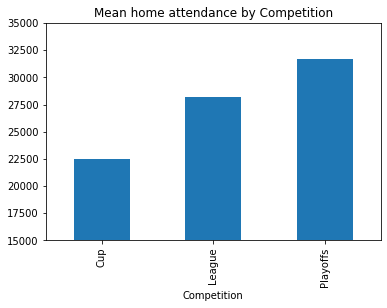

In [23]:
# Examining whether competition makes a real difference to the attendance. Looks like it could be a big factor. 

axes = plt.gca()
axes.set_ylim(15000,35000)
axes.set_title("Mean home attendance by Competition")

df[df["Home Side"] == "Derby County"].groupby("Competition").mean()["Attendance"].plot.bar()

**Creating and examining the evening feature**

In [5]:
# Creating a feature to determine whether a game was played in the evening or not. First need to strip away the timezone from the KO features. 

def strip_timezone(time):
    zones = ["GMT", "BST", "UTC", "()"]
    time = str(time)
    for zone in zones:
        time = time.replace(zone, "")
    return float(time.replace(":", "."))    

df["KO Time"] = df["KO Time"].apply(lambda time: strip_timezone(time))

# Then create a new feature to determine whether the game was played after 6pm.

df["Evening"] = df["KO Time"].apply(lambda x : "Yes" if (x > 18) else "No")

df.head()


,Date,Home Side,Away Side,Venue,KO Time,Gameweek,Attendance,Home Score,Away Score,Competition,Evening
0,2014-08-09,Derby County,Rotherham United,iPro Stadium,15.00,1,30105.0,1.0,0.0,League,No
1,2014-08-11,Carlisle United,Derby County,Brunton Park,19.45,First round,3481.0,0.0,2.0,Cup,Yes
2,2014-08-16,Sheffield Wednesday,Derby County,Hillsborough,15.00,2,25186.0,0.0,0.0,League,No
3,2014-08-19,Charlton Athletic,Derby County,The Valley,19.45,3,15317.0,3.0,2.0,League,Yes
4,2014-08-23,Derby County,Fulham,iPro Stadium,15.00,4,26577.0,5.0,1.0,League,No


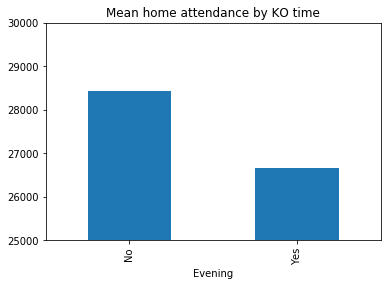

In [25]:
# Clear difference in average attendance between games played during the day and in the evening. 

axes = plt.gca()
axes.set_ylim(25000,30000)
axes.set_title("Mean home attendance by KO time")

df[df["Home Side"] == "Derby County"].groupby("Evening").mean()["Attendance"].plot.bar()

**Creating an examining the bank holiday feature**

In [26]:
# Using the holidays module, creating a list of every English bank holiday for the past ten years. 

from datetime import date
import holidays

df["Date"] = pd.to_datetime(df["Date"])
years = list(range(2010,2021))
bank_holidays = [hol[0] for hol in holidays.England(years = years).items()]

# Creating a new column to determine with a given date is in the bank holiday list. 

df["Bank Holiday"] = df["Date"].apply(lambda date: date in bank_holidays)

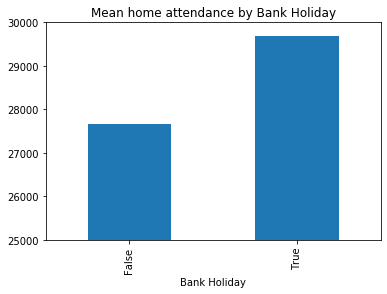

In [27]:
# Assessing the difference between bank holiday games and regular games. 

axes = plt.gca()
axes.set_ylim(25000,30000)
axes.set_title("Mean home attendance by Bank Holiday")

df[df["Home Side"] == "Derby County"].groupby("Bank Holiday").mean()["Attendance"].plot.bar()

**Assessing the side's form**

In [28]:
# Calculating the side's form over the last five games, indicated (roughly) by their goal difference over those games. 

GD = []

for index, row in df.iterrows():
    
    if index > 5:
        last_five_games = list(range(index-6, index-1))
        goal_difference = 0 
        
        for game in last_five_games:
            
            if df["Home Side"].iloc[game] == "Derby County":
                goal_difference += (df["Home Score"].iloc[game] - df["Away Score"].iloc[game])
            
            elif df["Home Side"].iloc[game] != "Derby County":
                goal_difference += (df["Away Score"].iloc[game] - df["Home Score"].iloc[game]) 
        
        GD.append(goal_difference)
        
# Adding the initial games that we don't have the previous data to find the rolling average for as NaN
        
for i in range(0,5):
    GD.insert(i, np.NaN)  
    
GD.append(np.NaN)    

df["Goal Difference last five"] = GD

In [29]:
# Goal difference over the last five appears to have little impact on the attendance in general though.

df["Attendance"].corr(df["Goal Difference last five"])

-0.026354029521303775

In [30]:
# If there is not much correlation with five games, is there a number of games where goal difference would start to effect attendance more?

GD_corr = pd.DataFrame()

# Creating a dataframe with the rolling goal differences of the last five games through to the last thirty. 

for games in range(5,31):
    
    GD = []
    
    for index, row in df.iterrows():
        
        if index > games:
            last_five_games = list(range((index-(games + 1)), index-1))
            goal_difference = 0 
            
            for game in last_five_games:
                
                if df["Home Side"].iloc[game] == "Derby County":
                    goal_difference += (df["Home Score"].iloc[game] - df["Away Score"].iloc[game])
                
                elif df["Home Side"].iloc[game] != "Derby County":
                    goal_difference += (df["Away Score"].iloc[game] - df["Home Score"].iloc[game]) 
            
            GD.append(goal_difference)

    for i in range(0,games):
        GD.insert(i, np.NaN)
    
    GD.append(np.NaN) 
    
    GD_corr[f"{games} games"] = GD
    
# Adding the attendance column from the original data set to the new data frame.     
        
GD_corr["Attendance"] = df["Attendance"]   

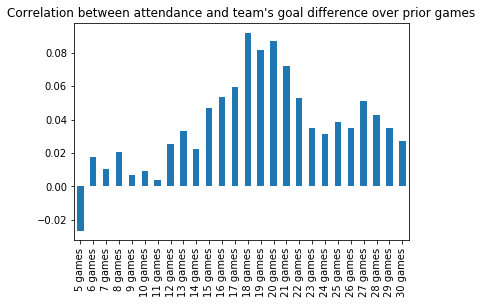

In [31]:
# Visualising the results. Seems there is a correlation between performance and attendance, but it takes around 20 games to make a difference. 

axes = plt.gca()
axes.set_title("Correlation between attendance and team's goal difference over prior games")
GD_corr.corr()["Attendance"][:-1].plot.bar()

In [32]:
df["Goal Difference last 20"] = GD_corr["20 games"]
df.drop("Goal Difference last five", axis=1, inplace = True)

In [49]:
df.to_csv("Derby_County_df", index=False)